# `dev`

In [1]:
%load_ext autoreload
%autoreload 2

import os
import nemo
import copy
import tqdm
import timeit
import shutil
import pathlib
import attrdict
import numpy as np

from ruamel import yaml
from Bio import pairwise2
from nemo.collections import asr as nemo_asr
from nemo.collections.asr.helpers import post_process_predictions, post_process_transcripts, word_error_rate

## Reordering

In [16]:
NGC_MAP = '~/Downloads/librivox-train-all.json'
LOCAL_MAP = [
    '/home/stanislavv/data/nemo-librispeech/train_clean_100.json',
    '/home/stanislavv/data/nemo-librispeech/train_clean_360.json',
    '/home/stanislavv/data/nemo-librispeech/train_other_500.json',
]
AD_HOC_MAP = '/home/stanislavv/data/librispeech/train-all.json'

In [25]:
DATA_BASE = pathlib.Path('/home/stanislavv/data/librispeech')

NGC_BASE = DATA_BASE / 'ngc'
NGC = [
    NGC_BASE / 'librivox-dev-clean.json',
    NGC_BASE / 'librivox-dev-other.json',
    NGC_BASE / 'librivox-test-clean.json',
    NGC_BASE / 'librivox-test-other.json',
    NGC_BASE / 'librivox-train-all.json',
]

LOCAL_BASE = DATA_BASE / 'local'
LOCAL = [
    LOCAL_BASE / 'dev_clean.json',
    LOCAL_BASE / 'dev_other.json',
    LOCAL_BASE / 'test_clean.json',
    LOCAL_BASE / 'test_other.json',
    LOCAL_BASE / 'train_all.json',
]

NEW_LOCAL_BASE = DATA_BASE / 'new-local'
NEW_LOCAL = [
    NEW_LOCAL_BASE / 'dev-clean.json',
    NEW_LOCAL_BASE / 'dev-other.json',
    NEW_LOCAL_BASE / 'test-clean.json',
    NEW_LOCAL_BASE / 'test-other.json',
    NEW_LOCAL_BASE / 'train-all.json',
]

In [9]:
def get_ngc_id(audio_file):
    return os.path.basename(audio_file)[:-4]

In [23]:
def remap(ngc_map, local_map, new_file):
    order = [
        get_ngc_id(example['audio_file']) 
        for example in nemo.collections.asr.parts.manifest.item_iter(str(ngc_map))
    ]
    
    local_id_index = [
        (get_ngc_id(example['audio_file']), i)
        for i, example in enumerate(nemo.collections.asr.parts.manifest.item_iter(str(local_map)))
    ]
    
    local_id_index_dict = dict(local_id_index)
    new_order = [local_id_index_dict[id_] for id_ in order]

    lines = []
    with open(local_map, 'r') as f:
        lines.extend(list(f))
    lines = [lines[id_] for id_ in new_order]
    
    with open(new_file, 'w') as f:
        for line in lines:
            f.write(line)

In [24]:
for ngc, local, new_local in zip(NGC, LOCAL, NEW_LOCAL):
    remap(ngc, local, new_local)

## Preparation

In [134]:
# NAME = 'dev-clean'
MAP = '/home/stanislavv/data/ljspeech/nemo/ljspeech_eval.json'
SAMPLE_RATE = 22050

In [135]:
runner = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
)

In [5]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/asr/configs/quartznet15x5.yaml'
yaml_loader = yaml.YAML(typ="safe")
with open(MODEL_CONFIG) as f:
    config = attrdict.AttrDict(yaml_loader.load(f))
config.sample_rate = SAMPLE_RATE
labels = list(config.labels)
str(labels)

'[\' \', \'a\', \'b\', \'c\', \'d\', \'e\', \'f\', \'g\', \'h\', \'i\', \'j\', \'k\', \'l\', \'m\', \'n\', \'o\', \'p\', \'q\', \'r\', \'s\', \'t\', \'u\', \'v\', \'w\', \'x\', \'y\', \'z\', "\'"]'

In [6]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/tts/configs/fasterspeech.yaml'
yaml_loader = yaml.YAML(typ="safe")
with open(MODEL_CONFIG) as f:
    pp_config = attrdict.AttrDict(yaml_loader.load(f))
pp_config.sample_rate = SAMPLE_RATE
pp_config.AudioToMelSpectrogramPreprocessor

AttrDict({'dither': 0.0, 'features': 80, 'frame_splicing': 1, 'highfreq': 8000, 'log': True, 'log_zero_guard_type': 'clamp', 'log_zero_guard_value': 1e-05, 'lowfreq': 0, 'mag_power': 1.0, 'n_fft': 1024, 'n_window_size': 1024, 'n_window_stride': 256, 'normalize': None, 'pad_to': 16, 'pad_value': -11.52, 'preemph': None, 'sample_rate': 24000, 'stft_conv': True, 'window': 'hann', 'window_size': None, 'window_stride': None})

In [ ]:
eval_dl_params = copy.deepcopy(config.AudioToTextDataLayer)
eval_dl_params.update(config.AudioToTextDataLayer["eval"])
del eval_dl_params["train"]
del eval_dl_params["eval"]
eval_dl_params['shuffle'] = False

In [13]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/asr/configs/quartznet15x5-libritts-durs.yaml'
yaml_loader = yaml.YAML(typ='safe')
with open(MODEL_CONFIG) as f:
    config = attrdict.AttrDict(yaml_loader.load(f))

config.sample_rate = SAMPLE_RATE
config.AudioToMelSpectrogramPreprocessor

AttrDict({'window_size': None, 'window_stride': None, 'n_window_size': 512, 'n_window_stride': 256, 'window': 'hann', 'normalize': 'per_feature', 'n_fft': 512, 'preemph': None, 'features': 64, 'lowfreq': 0, 'highfreq': None, 'log': True, 'log_zero_guard_type': 'clamp', 'log_zero_guard_value': 1e-05, 'dither': 0.0, 'pad_to': 16, 'frame_splicing': 1, 'stft_conv': True, 'pad_value': -11.52, 'mag_power': 2.0})

In [136]:
data_layer = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=MAP,
    sample_rate=config.sample_rate,
    labels=config.labels,
    batch_size=64,
    shuffle=False,
)

[NeMo I 2020-04-16 07:40:33 collections:144] Dataset loaded with 64 files totalling 0.12 hours
[NeMo I 2020-04-16 07:40:33 collections:145] 0 files were filtered totalling 0.00 hours


In [25]:
a, al, t, tl = next(iter(data_layer._dataloader))
a.shape, al.shape

(torch.Size([64, 220061]), torch.Size([64]))

In [26]:
np.unique(t.numpy().flatten())  # No big letters.

array([ 0, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       61, 62])

In [137]:
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(
    sample_rate=config.sample_rate, **config.AudioToMelSpectrogramPreprocessor
)
jasper_encoder = nemo_asr.JasperEncoder(
    feat_in=config.AudioToMelSpectrogramPreprocessor["features"], **config.JasperEncoder
)
jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=config.JasperEncoder["jasper"][-1]["filters"], num_classes=len(config.labels)
)
greedy_decoder = nemo_asr.GreedyCTCDecoder()

[NeMo I 2020-04-16 07:40:38 features:144] PADDING: 16
[NeMo I 2020-04-16 07:40:38 features:152] STFT using conv


In [138]:
audio_signal_e1, a_sig_length_e1, transcript_e1, transcript_len_e1 = data_layer()
processed_signal_e1, p_length_e1 = data_preprocessor(input_signal=audio_signal_e1, length=a_sig_length_e1)
encoded_e1, encoded_len_e1 = jasper_encoder(audio_signal=processed_signal_e1, length=p_length_e1)
log_probs_e1 = jasper_decoder(encoder_output=encoded_e1)
predictions_e1 = greedy_decoder(log_probs=log_probs_e1)

In [139]:
eval_tensors = [log_probs_e1, predictions_e1, transcript_e1, transcript_len_e1, encoded_len_e1, p_length_e1]
load_dir = '/home/stanislavv/data/checkpoints/nemo-qn15x5-libritts_tts-config_300epochs'
evaluated_tensors = runner.infer(tensors=eval_tensors, checkpoint_dir=load_dir)

[NeMo I 2020-04-16 07:40:41 actions:1468] Restoring JasperEncoder from /home/stanislavv/data/checkpoints/nemo-qn15x5-libritts_tts-config_300epochs/JasperEncoder-STEP-410400.pt
[NeMo I 2020-04-16 07:40:41 actions:1468] Restoring JasperDecoderForCTC from /home/stanislavv/data/checkpoints/nemo-qn15x5-libritts_tts-config_300epochs/JasperDecoderForCTC-STEP-410400.pt
[NeMo I 2020-04-16 07:40:41 actions:738] Evaluating batch 0 out of 1


In [140]:
references = post_process_transcripts(evaluated_tensors[2], evaluated_tensors[3], config.labels)
greedy_hypotheses = post_process_predictions(evaluated_tensors[1], config.labels)
word_error_rate(greedy_hypotheses, references)

0.12465878070973613

## Logic

In [75]:
labels = list(config.labels)
print(*labels)

  A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z , . ! ? ; : - / " ' ( ) [ ] { }


In [76]:
text = evaluated_tensors[2][0]
text_len = evaluated_tensors[3][0]
ctc_tokens = evaluated_tensors[1][0]
ctc_logprobs = evaluated_tensors[0][0]
ctc_len = evaluated_tensors[4][0]
mel_len = evaluated_tensors[-1][0]

In [77]:
text1 = text[0].numpy()
text_len1 = text_len[0].numpy().item()
ctc_tokens1 = ctc_tokens[0].numpy()
ctc_logprobs1 = ctc_logprobs[0].numpy()
ctc_len1 = ctc_len[0].numpy().item()
mel_len1 = mel_len[0].numpy().item()

In [78]:
text1 = list(text1[:text_len1])
ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
len(text1), len(ctc_tokens1), ctc_logprobs1.shape

(57, 476, (476, 70))

In [128]:
class PadProcesser:
    def __init__(self, labels):
        labels = labels + ['~']
        self.blank_id = len(labels) - 1
        self.space_id = labels.index(' ')
        self.labels_map = dict([(i, labels[i]) for i in range(len(labels))])
    
    def bound_text(self, tokens):
        return [self.space_id] + tokens + [self.space_id]
    
    def bound_ctc(self, tokens, logprobs):
        tokens = [self.space_id, self.blank_id] + tokens + [self.blank_id, self.space_id]
        
        logprobs = np.lib.pad(logprobs, ((2, 2), (0, 0)), 'edge')

        def swap(col, a, b):
            logprobs[col][a], logprobs[col][b] = logprobs[col][b], logprobs[col][a]
        
        first_token, last_token = tokens[2], tokens[-3]
        swap(0, first_token, self.space_id)
        swap(1, first_token, self.blank_id)
        swap(-1, last_token, self.space_id)
        swap(-2, last_token, self.blank_id)

        return tokens, logprobs
    
    def merge(self, tokens):
        output_tokens = []
        output_cnts = []
        cnt = 0
        for i in range(len(tokens)):
            if i != 0 and (tokens[i - 1] != tokens[i]):
                output_tokens.append(tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += 1

        output_tokens.append(tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == len(tokens), f'SUM_CHECK {sum(output_cnts)} vs {len(tokens)}'

        return output_tokens, output_cnts
    
    def merge_with_blanks(self, tokens, cnts, logprobs=None):
        def choose_sep(l, r, a, b):
            # `tokens[l] == a and tokens[r] == b`.
            sum_a, sum_b = logprobs[l, a], logprobs[l + 1:r + 1, b].sum()
            best_sum, best_sep = sum_a + sum_b, 0
            for sep in range(1, r - l):
                sum_a += logprobs[l + sep, a]
                sum_b -= logprobs[l + sep, b]
                if sum_a + sum_b > best_sum:
                    best_sum, best_sep = sum_a + sum_b, sep

            return best_sep
        
        output_tokens = []
        output_durs = []
        blank_cnt = 0
        total_cnt = 0
        for token, cnt in zip(tokens, cnts):
            total_cnt += cnt
            if token == self.blank_id:
                blank_cnt += cnt
                continue
            
            output_tokens.append(token)
            
            if logprobs is None:
                # Half half.
                left_cnt = blank_cnt // 2
            else:
                # Clever sep choice based on sum of log probs.
                left_cnt = choose_sep(
                    l=total_cnt - cnt - blank_cnt - 1,
                    r=total_cnt - cnt,
                    a=output_tokens[-1],
                    b=token,
                )
            right_cnt = blank_cnt - left_cnt
            blank_cnt = 0
            
            if left_cnt:
                output_durs[-1] += left_cnt
            output_durs.append(cnt + right_cnt)
        
        output_durs[-1] += blank_cnt

        assert sum(output_durs) == sum(cnts), f'SUM_CHECK {sum(output_durs)} vs {sum(cnts)}'

        return output_tokens, output_durs
    
    def align(self, output_tokens, gt_text):
        def make_str(tokens):
            return ''.join(self.labels_map[c] for c in tokens)
        
        s = make_str(output_tokens)
        t = make_str(gt_text)
        alignmet = pairwise2.align.globalxx(s, t, gap_char='%')[0]
        sa, ta, *_ = alignmet
        return sa, ta
    
    def generate(self, gt_text, alignment, durs):
        output_tokens = []
        output_cnts = []
        si, ti = 0, 0
#         print(len(durs))
        assert len(alignment[0]) == len(alignment[1])
        for sc, tc in zip(*alignment):
#             print(si, sc, ti, tc)
            if sc == '%' and tc == '%':
                print('NO WAY')
                continue
            
            if sc == '%':
                output_tokens.append(self.blank_id)
                output_cnts.append(durs[si])
                si += 1
            elif tc == '%':
                output_tokens.append(gt_text[ti])
                output_cnts.append(0)
                ti += 1
            else:
                output_tokens.append(gt_text[ti])
                output_cnts.append(durs[si])
                si += 1
                ti += 1

        assert sum(output_cnts) == sum(durs)
        
        return output_tokens, output_cnts

    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        # This adds +2 tokens.
        text = self.bound_text(text)
        # This add +4 tokens, 2 of them are blank.
        ctc_tokens, ctc_logprobs = self.bound_ctc(ctc_tokens, ctc_logprobs)

        ctc_tokens, ctc_cnts = self.merge(ctc_tokens)
        ctc_tokens, ctc_durs = self.merge_with_blanks(ctc_tokens, ctc_cnts, ctc_logprobs)
        
        alignment = self.align(text, ctc_tokens)
        tokens, cnts = self.generate(text, alignment, ctc_durs)
        tokens, durs = self.merge_with_blanks(tokens, cnts)
        assert tokens == text, 'EXACT_TOKENS_MATCH_CHECK'

        def adjust(start, direction, value):
            i = start
            while value != 0:
                dur = durs[i]
                
                if value < 0:
                    durs[i] = dur - value
                else:
                    durs[i] = max(dur - value, 0)
                
                value -= dur - durs[i]
                i += direction

        adjust(0, 1, 4)
        adjust(-1, -1, sum(durs) - mel_len)  # Including 4 suffix bound tokens.
        assert durs[0] >= 0, f'{durs[0]}'
        assert durs[-1] >= 0, f'{durs[-1]}'
        
        durs = np.array(durs, dtype=np.long)
        assert durs.shape[0] == len(text), f'LEN_CHECK {durs.shape[0]} vs {len(text)}'
        assert np.sum(durs) == mel_len, f'SUM_CHECK {np.sum(durs)} vs {mel_len}'

        return durs

processer = PadProcesser(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

array([ 3,  1,  4,  8,  2,  1,  2,  5,  3,  2, 17,  1,  4,  3,  2, 10,  4,
        2,  8,  1,  4,  6,  4,  2,  2,  5,  7,  3,  3, 13,  4,  8,  2,  2,
        2, 10,  2,  1,  2,  7, 18,  4,  1,  9,  6,  4,  2,  1, 12,  6,  2,
        8,  7,  4,  2,  4,  2,  3,  9,  6, 11,  5, 13, 29, 19,  3,  5, 39,
        5,  6, 24, 17,  3])

In [129]:
class Seq:
    def __init__(self, tokens, cnts=None):
        if cnts is None:
            cnts = np.ones(len(tokens), dtype=np.long)

        assert len(tokens) == len(cnts)
        self.tokens = tokens
        self.cnts = cnts
    
    def __repr__(self):
        return repr(list(zip(self.tokens, self.cnts)))
    
    @property
    def total(self):
        return sum(self.cnts)
    
    def merge(self):
        output_tokens = []
        output_cnts = []
        
        cnt = 0
        for i in range(len(self.tokens)):
            if i != 0 and (self.tokens[i - 1] != self.tokens[i]):
                output_tokens.append(self.tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += self.cnts[i]

        output_tokens.append(self.tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == sum(self.cnts), \
            f'SUM-CHECK {sum(output_cnts)} vs {sum(self.cnts)}'

        return Seq(output_tokens, output_cnts)
    
    def full_pad(self, blank_id, blank_cnt=1):
        output_tokens = [blank_id]
        output_cnts = [blank_cnt]

        for token, cnt in zip(self.tokens, self.cnts):
            output_tokens.append(token)
            output_cnts.append(cnt)
            
            output_tokens.append(blank_id)
            output_cnts.append(blank_cnt)
        
        return Seq(output_tokens, output_cnts)
    
    def adjust_cnt(self, value, start=-1, direction='left'):
        tokens, cnts = self.tokens, self.cnts.copy()
        
        i, di = start, -1 if direction == 'left' else 1
        while value != 0:
            cnt = cnts[i]

            if value < 0:
                cnts[i] = cnt - value
            else:
                cnts[i] = max(cnt - value, 0)

            value -= cnt - cnts[i]
            i += di
        
        return Seq(tokens, cnts)
    
    def split2(self):
        tokens1, cnts1 = [], []
        tokens2, cnts2 = [], []
        turn = 1
        
        for token, cnt in zip(self.tokens, self.cnts):
            if turn == 1:
                tokens1.append(token)
                cnts1.append(cnt)
            else:
                tokens2.append(token)
                cnts2.append(cnt)
            
            turn = 1 if turn == 2 else 2
        
        return Seq(tokens1, cnts1), Seq(tokens2, cnts2)

In [131]:
class FullProcessor(PadProcesser):
    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        text = Seq(text).full_pad(self.blank_id)
        ctc = Seq(ctc_tokens).merge().full_pad(self.blank_id, blank_cnt=0).merge()
        
        alignment = self.align(text.tokens, ctc.tokens)
        gen = Seq(*self.generate(text.tokens, alignment, ctc.cnts)).merge()
#         gen = gen.merge().adjust_cnt(gen.total - mel_len)
        
        # Two durs conditions.
        assert gen.tokens == text.tokens
        assert gen.total == mel_len
        
        blanks, text = gen.split2()
        blanks = np.array(blanks.cnts, dtype=np.long)
        cnts = np.array(text.cnts, dtype=np.long)
        
        assert len(blanks) == len(cnts) + 1
        
        return blanks, cnts


processer = FullProcessor(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

(array([ 5,  3,  6,  1,  0,  0,  3,  2,  1, 15,  0,  2,  3,  0,  8,  1,  1,
         4,  2,  2,  5,  3,  0,  1,  4,  5,  2,  1, 12,  3,  2,  5,  1,  0,
         8,  1,  0,  1,  4, 15,  4,  3,  8,  4,  2,  0,  0, 11,  2,  3,  0,
        11,  3,  0,  0,  3,  0,  5, 13,  6,  2, 14,  0, 43,  4,  2, 40,  4,
         2,  5, 37,  1]),
 array([1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 3, 1, 0, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1]))

In [132]:
ctc_labels = ['_'] + labels[1:] + ['~']
print('GT: ', *(ctc_labels[c] for c in text1))
print('CTC: ', *(ctc_labels[c] for c, _ in itertools.groupby(ctc_tokens1)))

GT:  a s _ t h e _ i n s p e c t o r s _ o f _ p r i s o n s _ f o u n d _ t h e m _ i n _ e i g h t e e n _ t h i r t y - f i v e _ t o _ s i x .
CTC:  ~ a ~ s ~ _ ~ t h e ~ _ ~ i ~ n ~ s p ~ e ~ c t ~ o ~ r ~ s ~ _ ~ o ~ f ~ _ ~ p r ~ i ~ s ~ o ~ n ~ s ~ _ ~ f ~ o ~ u ~ n d ~ _ ~ t h ~ e ~ m ~ _ ~ i ~ n ~ _ ~ e ~ i g h ~ t ~ e ~ e n ~ _ ~ t h i ~ r t ~ y ~ _ ~ f ~ i ~ v e ~ _ ~ t ~ o ~ _ ~ s ~ i ~ x ~ . ~


In [18]:
f = lambda: processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
n, m = 10000, 280000
(timeit.timeit(f, number=n) / n) * m

944.1908576488495

In [141]:
# NOTE: This is going pretty fast.
durs_dir = pathlib.Path('/home/stanislavv/data/librimeta/durs/ljspeech_300epochs-qn15x5-eqlen')
name = f'ljspeech_eval'
durs_dir.mkdir(exist_ok=True)
# k = -1

durs = []
for batch in tqdm.tqdm(zip(*evaluated_tensors), total=len(data_layer) // 64):
    text = batch[2].numpy()
    text_len = batch[3].numpy()
    ctc_tokens = batch[1].numpy()
    ctc_logprobs = batch[0].numpy()
    ctc_len = batch[4].numpy()
    mel_len = batch[-1].numpy()

    for text1, text_len1, ctc_tokens1, ctc_logprobs1, ctc_len1, mel_len1 in zip(
        text, text_len, ctc_tokens, ctc_logprobs, ctc_len, mel_len
    ):
        text1 = list(text1[:text_len1])
        ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
        ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
        mel_len1 = mel_len1.item()
        
        assert mel_len1 == ctc_len1

        durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
        
        durs.append(durs1)


np.save(durs_dir / f'{name}.npy', durs, allow_pickle=True)

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


## Analysis

In [123]:
np.unique(max_blanks)

array([  14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
         25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   94,   95,   96,   97,   98,   99,  100,  101,
        102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,
        113,  114,  116,  117,  118,  120,  122,  124,  126,  128,  130,
        131,  132,  134,  136,  138,  140,  142,  144,  146,  148,  150,
        152,  154,  156,  158,  160,  162,  164,  166,  168,  170,  172,
        174,  176,  178,  180,  182,  184,  186,  188,  190,  192,  194,
        196,  198,  200,  202,  204,  206,  208,  2

In [118]:
max(b.max() for b, _ in durs)

1130

In [119]:
max(d.max() for _, d in durs)

34

In [129]:
import matplotlib.pyplot as plt
import itertools

In [142]:
num, total = 0, 0
for b, _ in durs:
    num += (b > 30).sum()
    total += len(b)

num, total, (num / total * 100)

(1167549, 49408497, 2.363053059476794)

In [144]:
num, total = 0, 0
for _, d in durs:
    num += (d > 15).sum()
    total += len(d)

num, total, (num / total * 100)

(31619, 49129870, 0.06435799646935765)



  0%|          | 0/278627 [00:00<?, ?it/s]

  5%|▌         | 14127/278627 [00:00<00:01, 141258.35it/s]

 10%|▉         | 26700/278627 [00:00<00:01, 136209.42it/s]

 13%|█▎        | 36747/278627 [00:00<00:01, 123074.31it/s]

 18%|█▊        | 49495/278627 [00:00<00:01, 124361.40it/s]

 22%|██▏       | 62138/278627 [00:00<00:01, 124971.96it/s]

 27%|██▋       | 74744/278627 [00:00<00:01, 125295.71it/s]

 31%|███▏      | 87506/278627 [00:00<00:01, 125982.50it/s]

 36%|███▌      | 100505/278627 [00:00<00:01, 127157.53it/s]

 41%|████      | 113237/278627 [00:00<00:01, 127205.44it/s]

 45%|████▌     | 125793/278627 [00:01<00:01, 126704.68it/s]

 50%|████▉     | 138547/278627 [00:01<00:01, 126951.90it/s]

 54%|█████▍    | 151085/278627 [00:01<00:01, 126474.15it/s]

 59%|█████▊    | 163550/278627 [00:01<00:00, 125234.73it/s]

 63%|██████▎   | 175949/278627 [00:01<00:00, 123761.67it/s]

 68%|██████▊   | 188242/278627 [00:01<00:00, 122351.37it/s]

 72%|███████▏  | 200423/278627 [00:01<00:00, 1

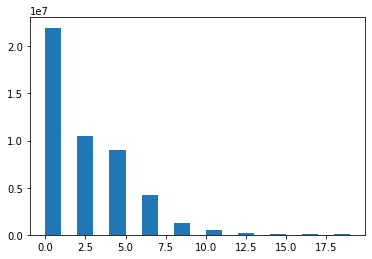

In [134]:
plt.hist(
    list(itertools.chain.from_iterable(b for b, _ in tqdm.tqdm(durs))),
    bins=range(20),
);